In [1]:
import jax.numpy as jnp
import jax
import os

jax.config.update('jax_default_device',jax.devices()[1])
jax.config.update('jax_enable_x64',True)

from jsindy.trajectory_model import DataAdaptedRKHSInterpolant
from jsindy.sindy_model import JSINDyModel
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import LMSolver, AlternatingActiveSetLMSolver
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings


from equinox import tree_pprint
import matplotlib.pyplot as plt

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time
from equinox import tree_pprint
from jsindy.kernels import softplus_inverse

In [ ]:
dt = 0.2
noise_var = 0.
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = LorenzExp(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

trajectory_model = DataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel()
optsettings = LMSettings(
    max_iter = 1000,
    print_every = 100,
    min_alpha = 1e-15,
    max_alpha = 1000,
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=AlternatingActiveSetLMSolver(beta_reg=0.001,solver_settings=optsettings),
    feature_names=expdata.feature_names
)

In [3]:
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.91962264e-21, dtype=float64), 'data_weight': Array(100., dtype=float64), 'colloc_weight': Array(10000., dtype=float64)}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 1.346e+13, gradnorm = 6.643e+15, alpha = 3.0, improvement_ratio = 0.6585
Iteration 1, loss = 1.274e+13, gradnorm = 3.939e+16, alpha = 27.34, improvement_ratio = 0.05342
Iteration 2, loss = 3.052e+11, gradnorm = 1.233e+16, alpha = 22.78, improvement_ratio = 0.976
Iteration 3, loss = 7.253e+10, gradnorm = 4.109e+15, alpha = 22.78, improvement_ratio = 0.7624
Iteration 4, loss = 8.286e+09, gradnorm = 1.009e+15, alpha = 18.98, improvement_ratio = 0.8858
Iteration 5, loss = 9.153e+08, gradnorm = 2.93e+14, alpha = 15.82, improvement_ratio = 0.8895
Iteration 100, loss = 44.24, gradnorm = 1.163e+09, alpha = 0.005191, improvement_ratio = 0.9643
Iteration 200, loss = 3.139, gradnorm = 3.911e+07, alpha = 6.268e-11, improvement_ratio = 0.9984
Iteration 300, loss = 1.142, gradnorm = 2.556e+06, alpha = 8.333e-16, improvement_ratio = 0.9998
Iteration 400, loss = 0.8804, gradnorm = 2.596e+05, alpha = 8.333e-16, improvement_ratio = 1.0
Iteration 500, loss = 0.807, gradnorm = 4.632e+0

In [4]:
model.print()

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


In [5]:
metrics

{'coeff_mets': {'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0,
  'coeff_rel_l2': 5.197429984341899e-07,
  'coeff_rmse': 2.9918890491274277e-06,
  'coeff_mae': 7.462971805131483e-07},
 'data_mets': {'mse': Array(7.9522763e-10, dtype=float64),
  'rmse': np.float64(2.8199780664534457e-05),
  'mae': np.float64(2.072232649858013e-05),
  'max_abs_error': np.float64(9.739781012285675e-05),
  'normalized_mse': Array(2.04410571e-13, dtype=float64),
  'relative_l2_error': np.float64(4.52045792374048e-07)}}

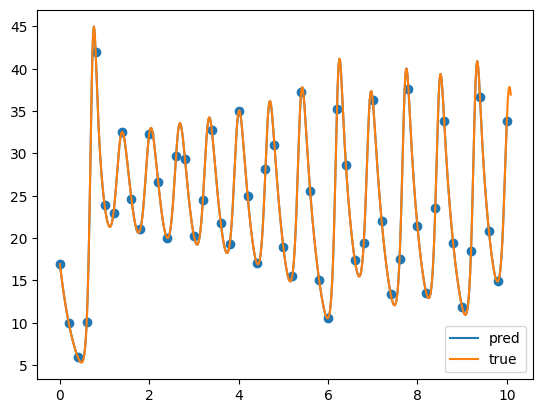

In [6]:
tgrid = jnp.linspace(0,10,500)
xpred = model.predict_state(tgrid)

index = 2
plt.plot(tgrid,xpred[:,index],label = 'pred')
plt.plot(expdata.t_true,expdata.x_true[:,index],label = 'true')

plt.scatter(expdata.t_train,expdata.x_train[:,index])
plt.legend()